In [29]:
# IMPORTS

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow
import lightkurve as lk
import cv2
import io
import warnings
from sklearn.model_selection import train_test_split


from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [30]:
warnings.filterwarnings("ignore") # didnt work

In [31]:
# PHASE AND BIN FUNCTION

def phase_and_bin(data,period,t0,bin_time):
    data_phased = data.fold(period=period,epoch_time=t0)
    data_binned = data_phased.bin(bin_time)
    return data_binned


In [32]:
# DOWNLOAD (& ADD TO BIG ARRAY)

def download(search):

    lc = search.download()
    
    if lc is not None:
        
        fig,ax = plt.subplots()
        ax.scatter(lc.time.value.tolist(), lc.flux.value.tolist(), color='k')
        ax.autoscale()
        ax.set_xlabel('Time (BTJD)')
        ax.set_ylabel('Flux')
        fig.show()
        io_buf = io.BytesIO()
        fig.savefig(io_buf,format="raw")
        io_buf.seek(0)
        img_arr = (np.frombuffer(io_buf.getvalue(),dtype=np.uint8)).reshape(288,-1)
        io_buf.close()

        return img_arr

In [33]:
# GET ARRAY OF IMAGE ARRAYS FOR A FILE

def get_lightcurves(filename,length):

    tbl = pd.read_csv(os.path.abspath(filename),delimiter=",",comment="#")
    
    colnames = tbl.columns.values.tolist()
    if "tid" in colnames:
        TICs = tbl["tid"].astype(str)
    elif "tic_id" in colnames:
        TICs = tbl["tic_id"].astype(str).str[4:]
    else:
        print("No TIC ID column found.")

    #print(np.shape(TICs))

    pics = []

    for x in range(0,length): # change upper bound as needed
        name = TICs[x]
        
        search = lk.search_lightcurve(target=("TIC " + name),author="SPOC")
        pic = download(search)
        
        if pic is not None:
            pics.append(pic)
    
    shape = int(len(pics))

    print("Shape is " + str(shape))
        
    return pics, shape
        

In [34]:
# CREATE TRAIN AND TEST DATASETS

def predictExo(exotrainfile,noexotrainfile,testfile):

    exotraindata, trainshape = get_lightcurves(exotrainfile,200) # / 255 for the data
    noexotraindata, train2shape = get_lightcurves(noexotrainfile,69)

    exotraindata = np.asarray(exotraindata)
    noexotraindata = np.asarray(noexotraindata)

    print(exotraindata[0])

    print(np.shape(exotraindata))

    exolabels = np.ones(trainshape)
    noexolabels = np.zeros(train2shape)

    traindata = np.concatenate((exotraindata,noexotraindata))
    trainlabels = np.concatenate((exolabels,noexolabels))

    #train_exo, test_exo, train_labels, test_labels = train_test_split(traindata,trainlabels)


    print("Train data shape is " + str(np.shape(traindata)))
    traindata = tensorflow.reshape(traindata,[trainshape+train2shape,1,288,1728])

    # NON-2D CNN MODEL

    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(1,288,1728)),
        keras.layers.Dense(16,activation="relu"),
        keras.layers.Dense(16,activation="relu"),
        keras.layers.Dense(1,activation="sigmoid")
    ])

    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

    # TRAIN DATA

    model.fit(
        traindata,
        trainlabels,
        batch_size = 8,
        epochs = trainshape+train2shape,
    )

    Y, testshape = get_lightcurves(testfile,10) # this returns an array of images!
    Y = np.asarray(Y)

    tble = pd.read_csv(os.path.abspath(testfile),delimiter=",",comment="#")
    TICid = tble["tic_id"].astype(str)
    
    X = tensorflow.reshape(Y,[testshape,1,288,1728])
    probability = model.predict(X)
    val = np.round(probability).tolist()
    
    for x in range(0,len(val)):
        
        fig, ax = plt.subplots()
        ax.imshow(Y[x],aspect=4,cmap="gray")
        plt.show()

        if val[x] == [1.0]:
            print("Exoplanet candidate detected! ID: " + TICid[x])
        elif val[x] == [0.0]:
            print("No exoplanet detected. ID: " + TICid[x])

223
223
228
228
228
228
228
209
209
209
209
209
209
209
226
226
226
226
226
226
227
224
224
216


201
223


223
221
211
211
211
211
218
218
218
217
230
220
220
220
220
220
220
220
220
220
220
216
216
216
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
227
222
222
222
228
228
228
228
228
225
225
225
225
222
222
222
222
222
222
225
215
215
223
213
228
226
226
226
226
226
226
226
226
226
226
207
210
234
218
218
218
218
224
224
224
213
215
226
216
219
219
205
205
205
210
210
210
210
211
211
215


226
212
212
212
212
212
Shape is 167
224
222
220
219
219
220
215
224
229
218
224
221
215
225
215
222
218
221
207
219
212
216
209
214
215
198
205
219
225
209
211
216
215
222
213
211
213
212
207
207
220
214
215
216
219
213
215
215
217
206


210
218


212
230
210
213


206
216
210
211
Shape is 60
[[255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255   0]
 ...
 [255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255   0]
 [255 255 255 ... 255 255   0]]
(167, 288, 1728)
Train data shape is (227, 288, 1728)
Epoch 1/227
29/29 [==============================] - 1s 20ms/step - loss: 6205.5562 - accuracy: 0.6344
Epoch 2/227
29/29 [==============================] - 1s 20ms/step - loss: 1762.1338 - accuracy: 0.7313
Epoch 3/227
29/29 [==============================] - 1s 20ms/step - loss: 1254.4894 - accuracy: 0.7709
Epoch 4/227
29/29 [==============================] - 1s 20ms/step - loss: 317.8276 - accuracy: 0.9031
Epoch 5/227
29/29 [==============================] - 1s 20ms/step - loss: 244.6032 - accuracy: 0.9251
Epoch 6/227
29/29 [==============================] - 1s 20ms/step - loss: 438.7482 - accuracy: 0.8943
Epoch 7/227
29/29 [==============================] - 1s 20ms/step - loss: 215.3040 - accuracy: 0.9207
Epoch 8/2

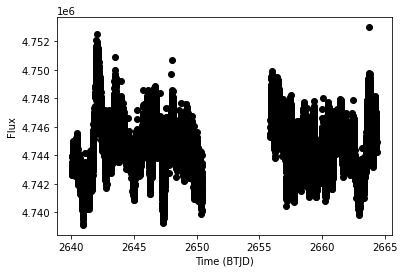

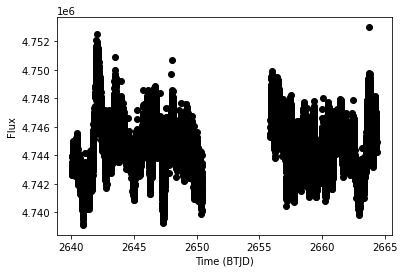

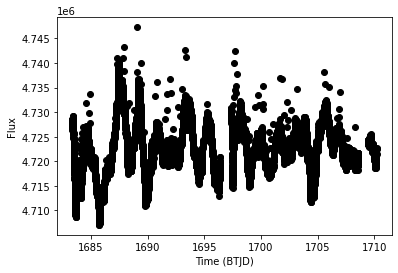

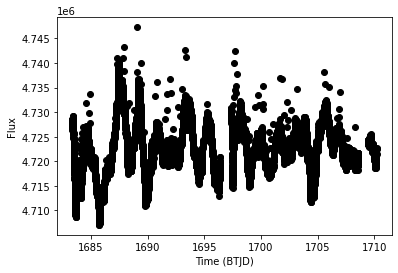

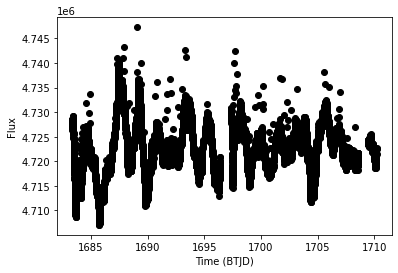

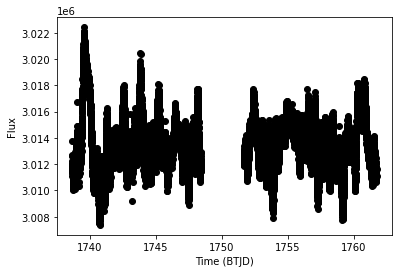

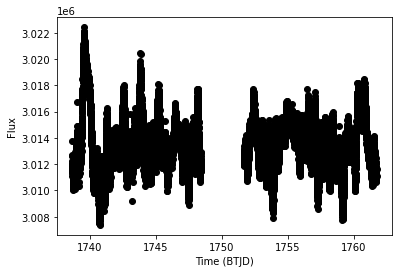

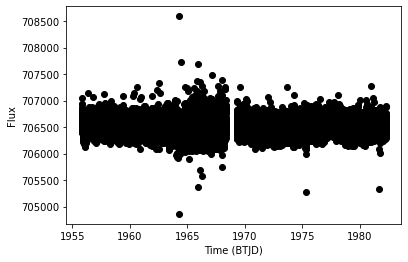

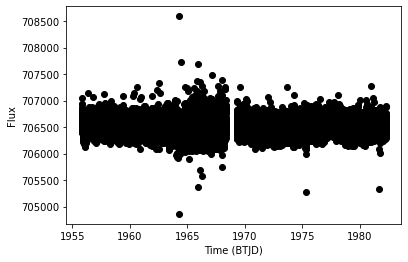

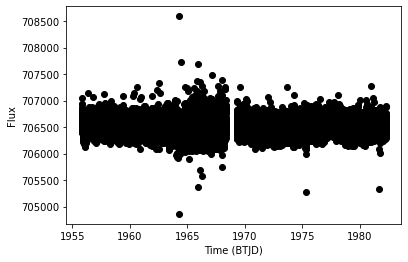

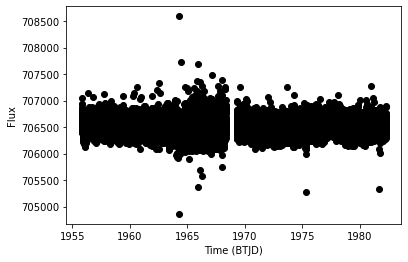

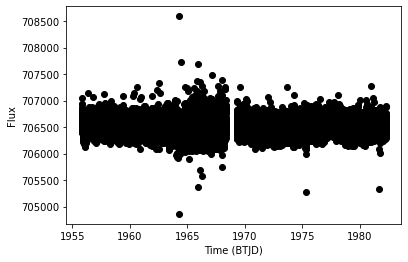

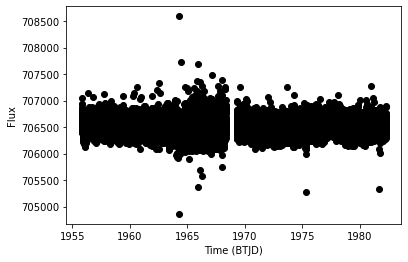

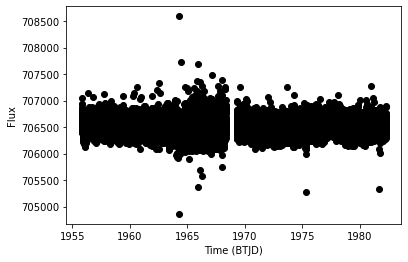

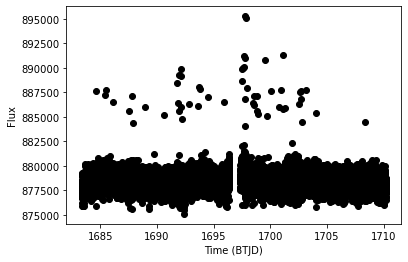

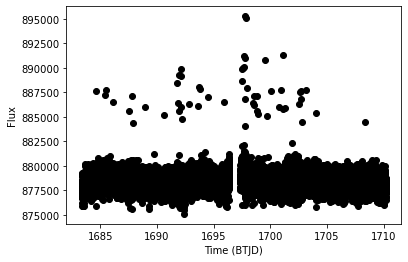

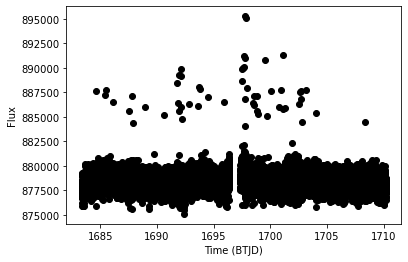

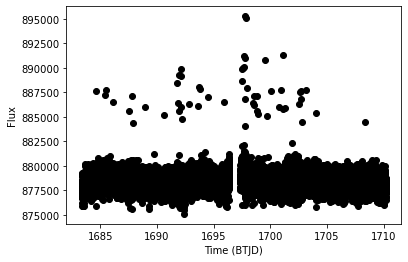

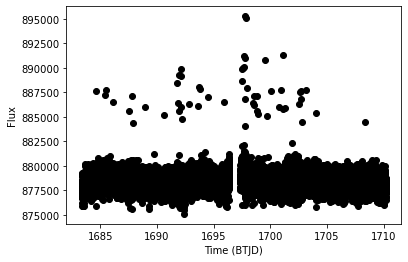

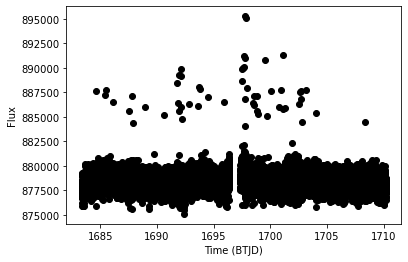

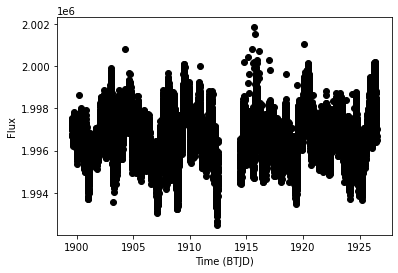

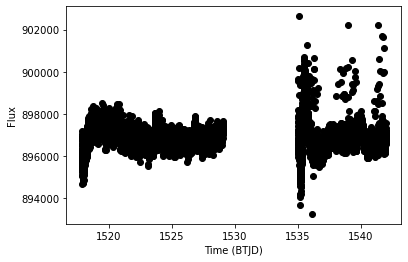

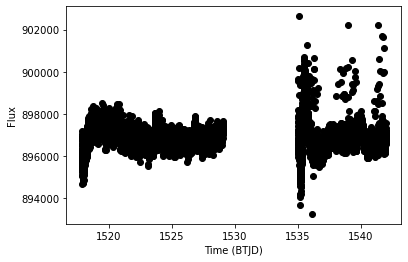

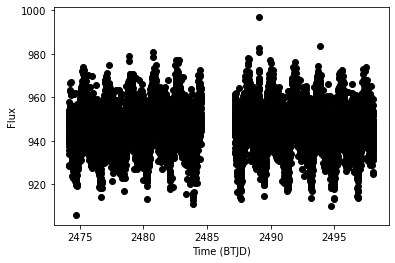

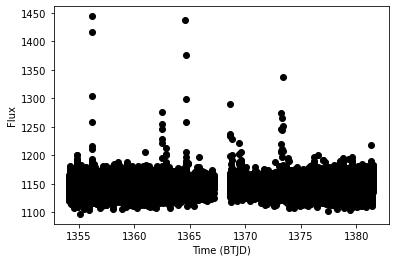

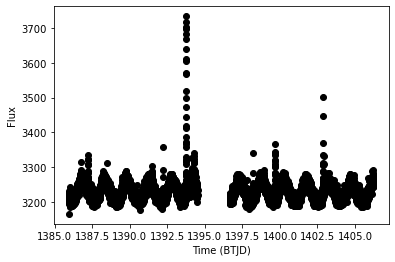

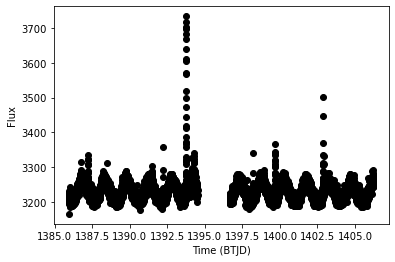

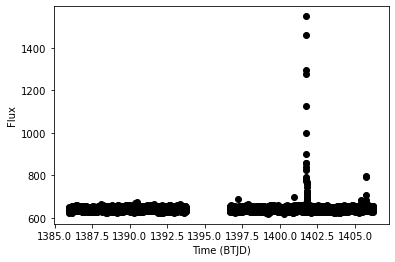

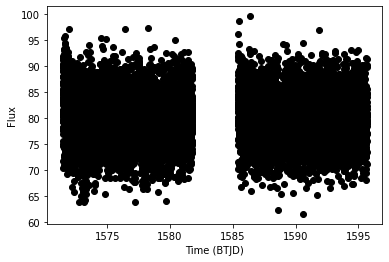

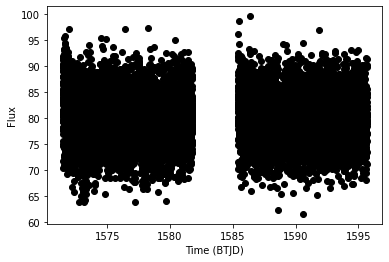

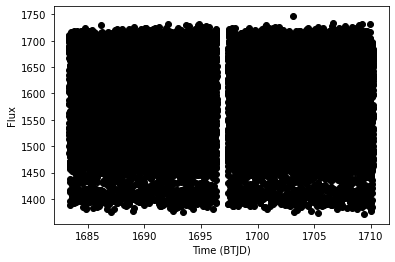

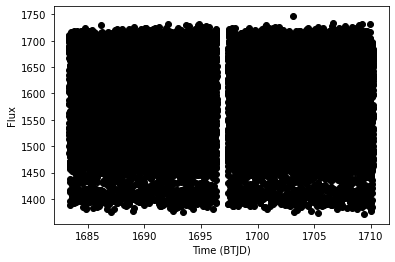

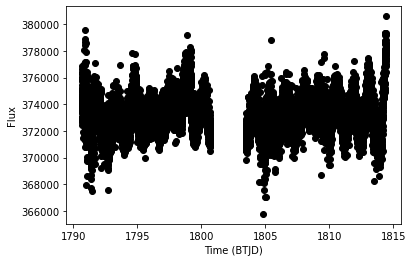

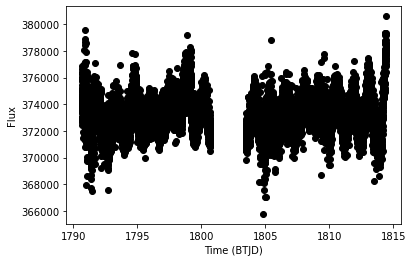

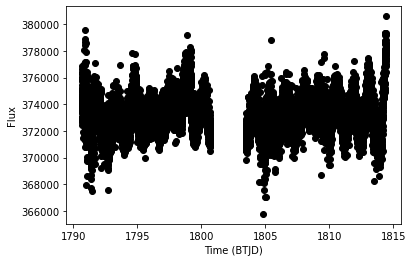

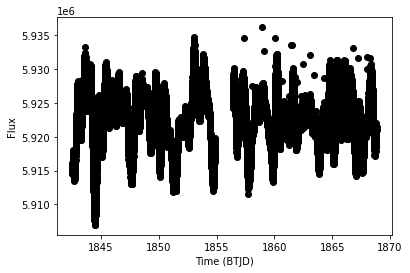

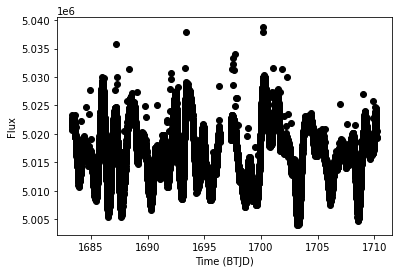

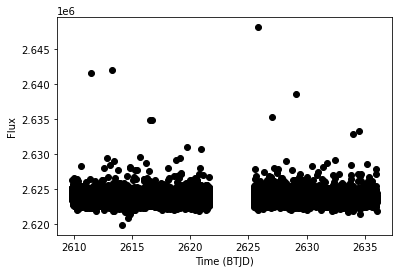

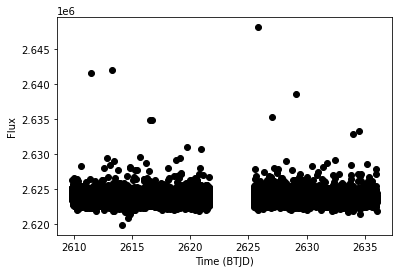

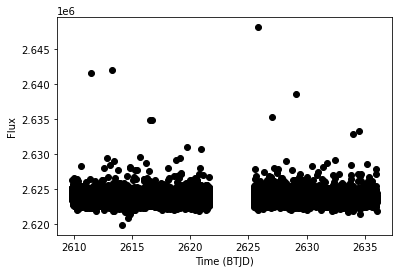

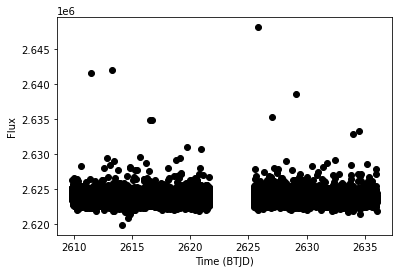

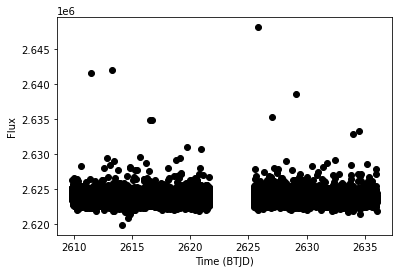

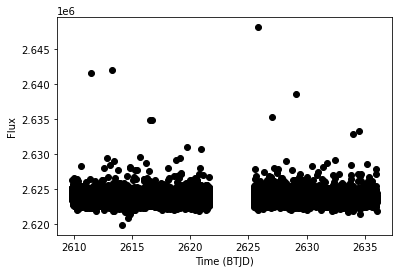

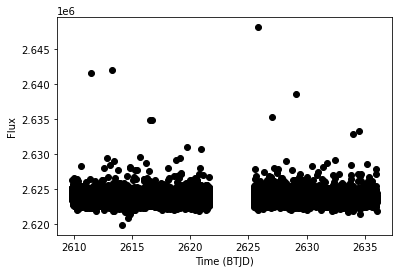

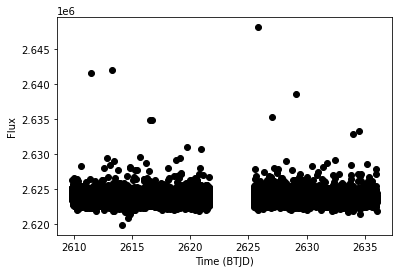

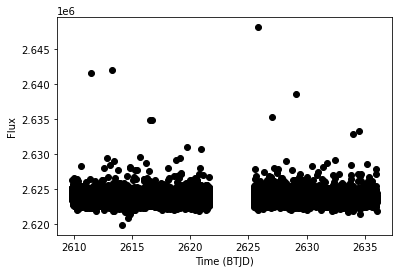

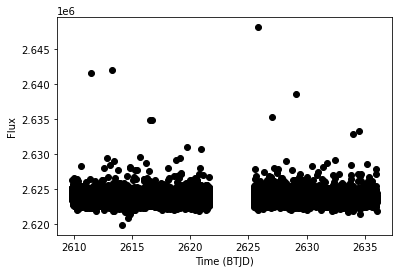

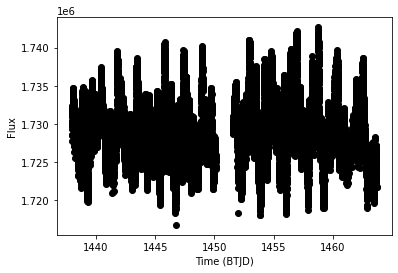

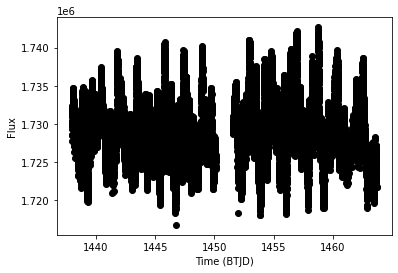

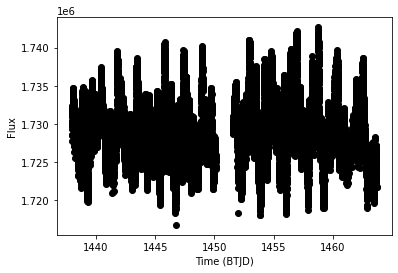

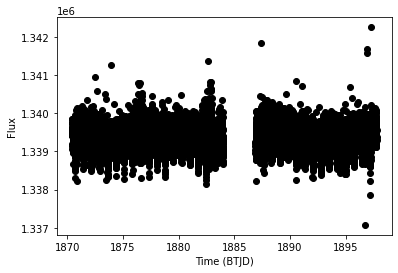

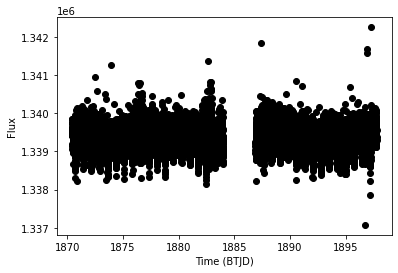

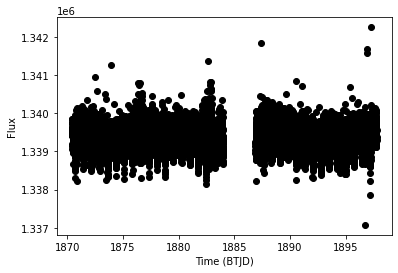

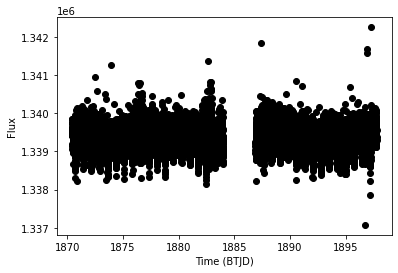

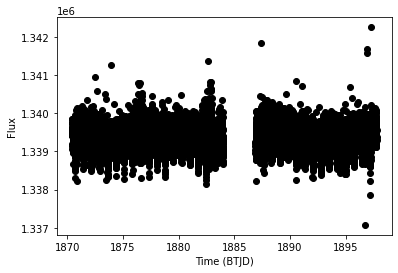

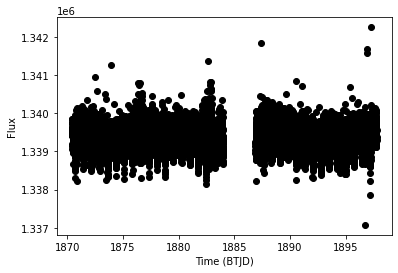

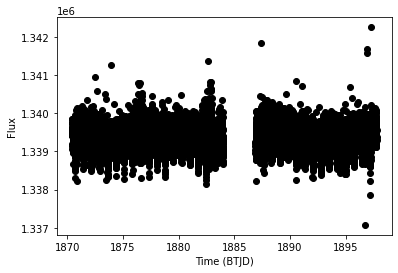

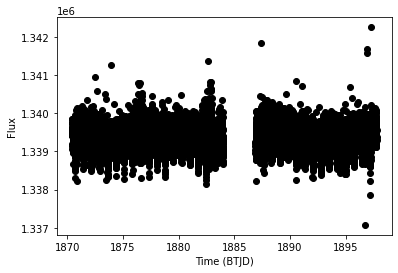

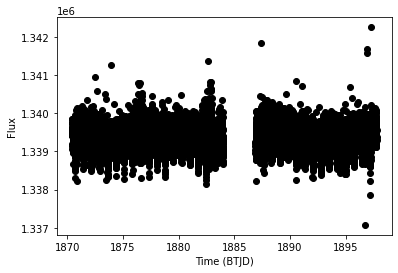

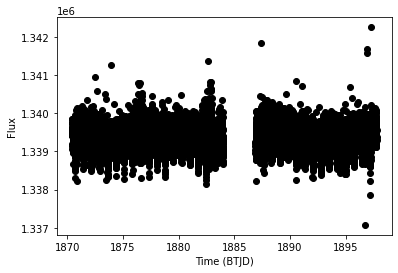

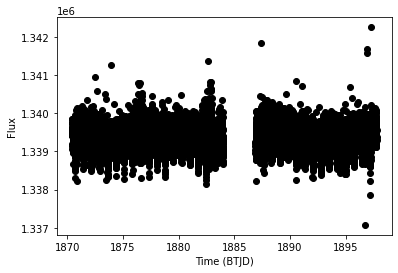

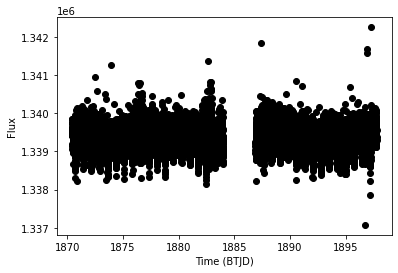

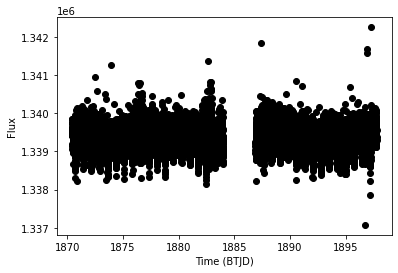

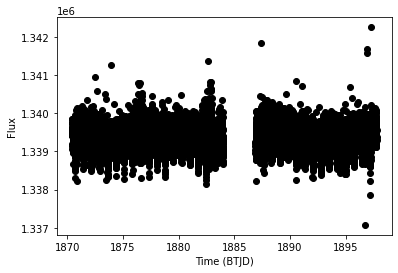

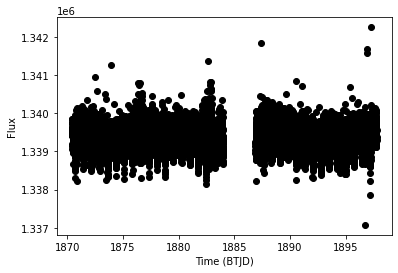

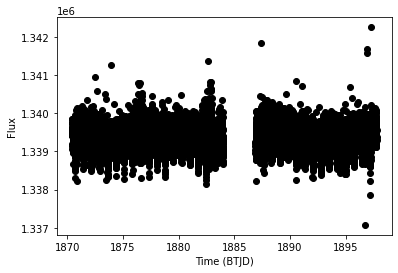

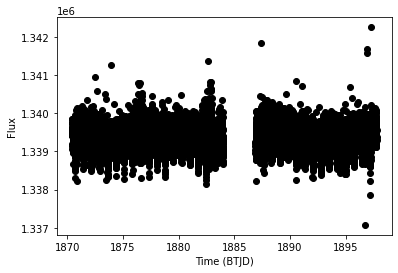

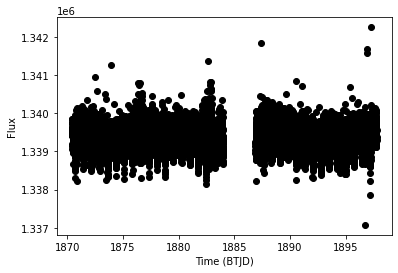

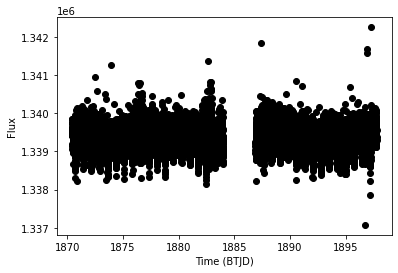

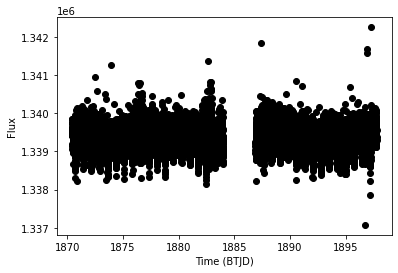

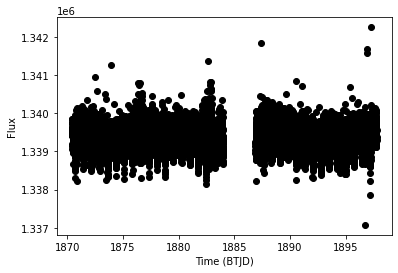

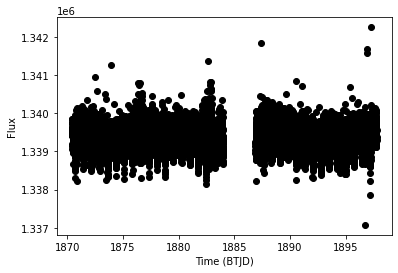

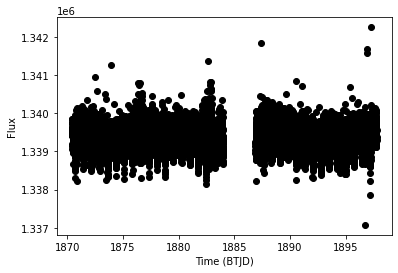

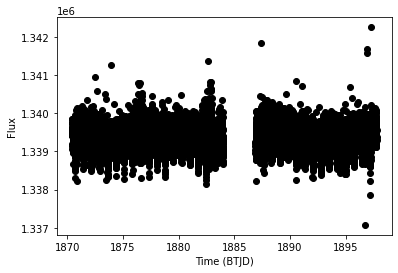

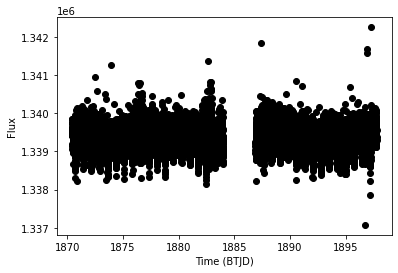

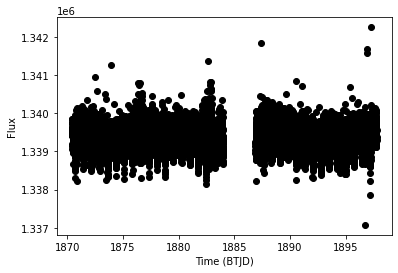

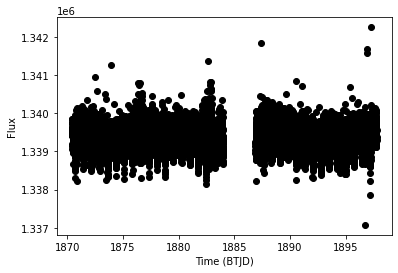

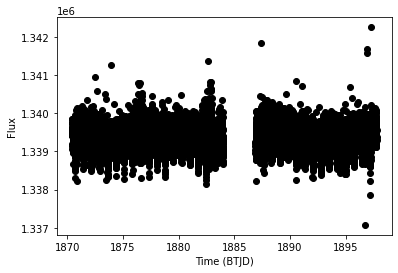

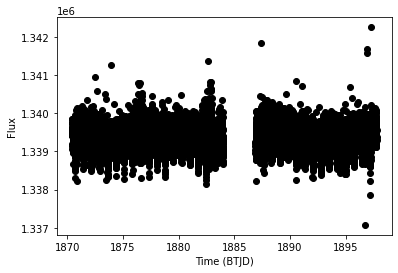

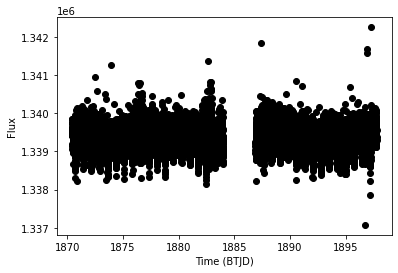

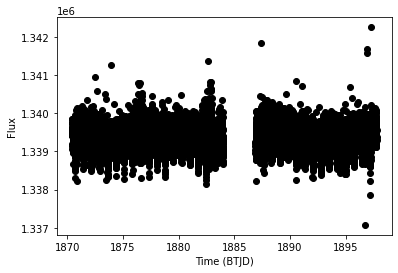

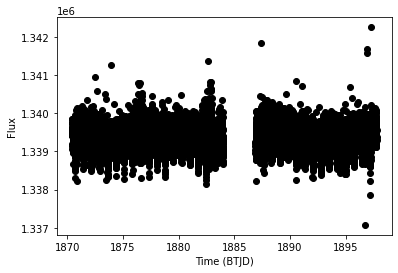

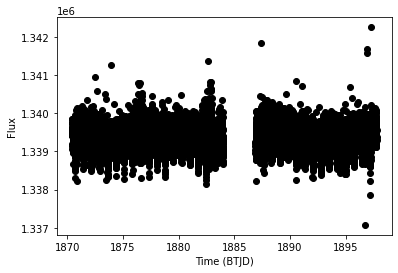

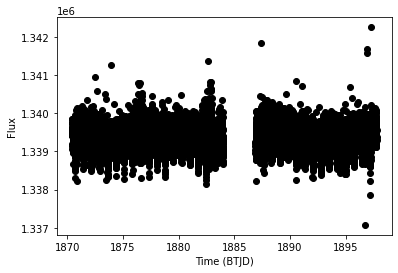

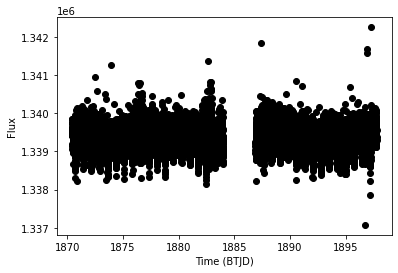

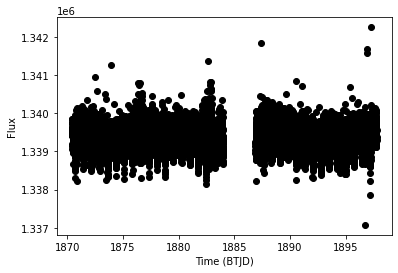

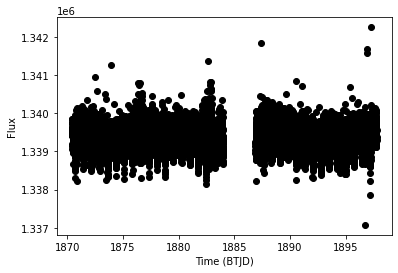

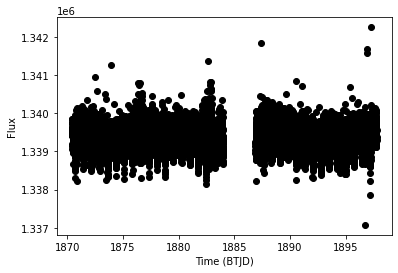

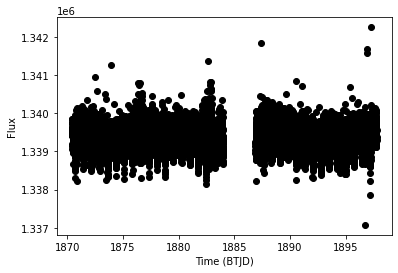

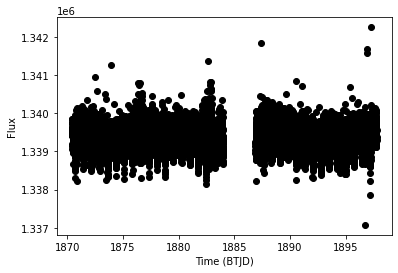

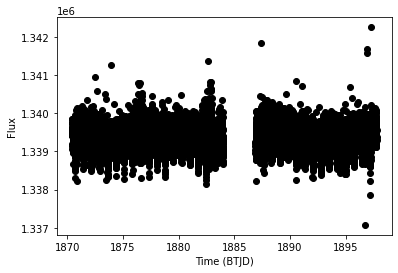

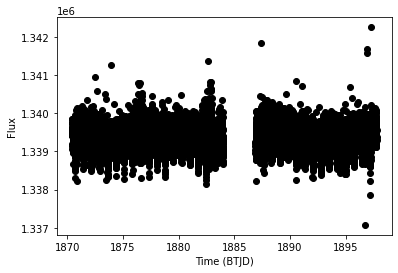

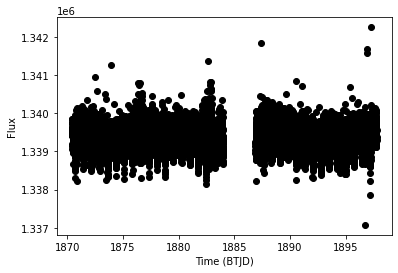

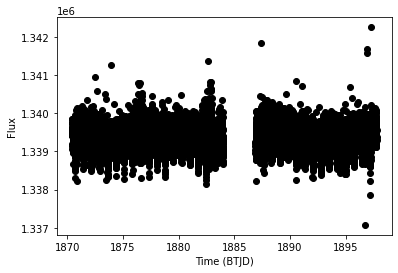

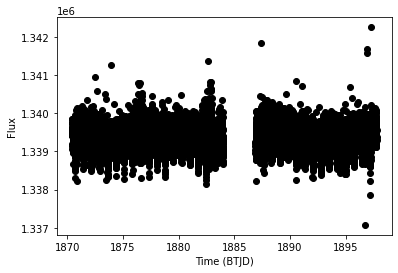

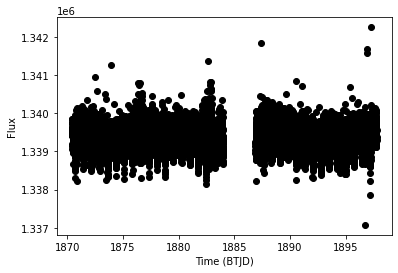

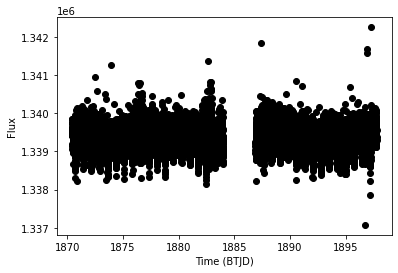

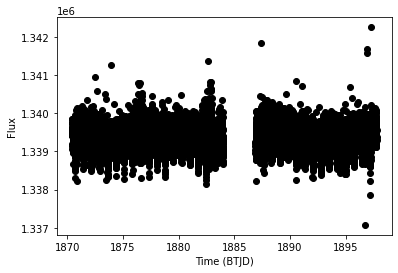

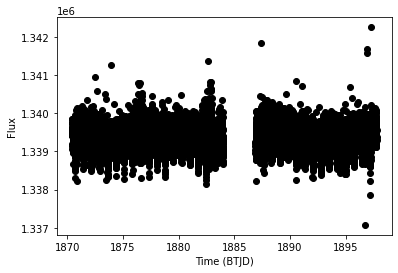

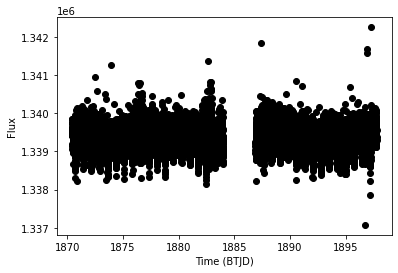

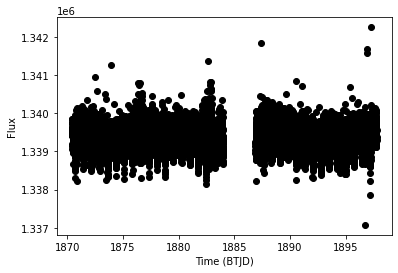

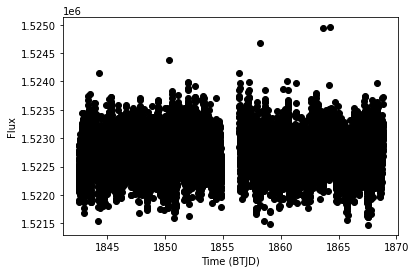

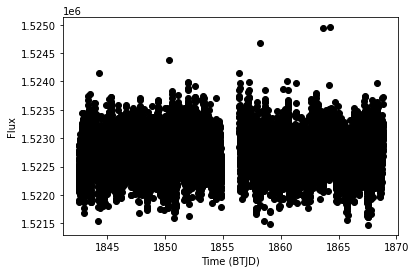

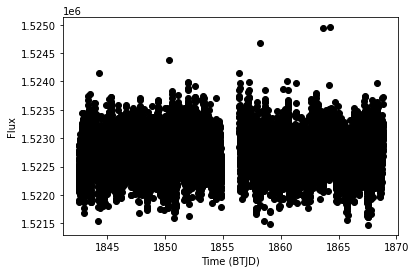

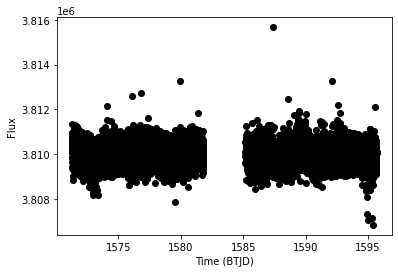

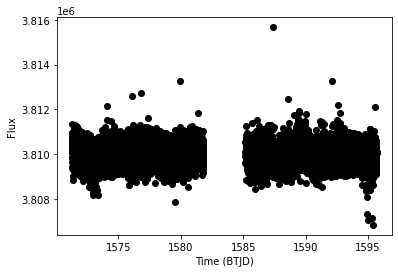

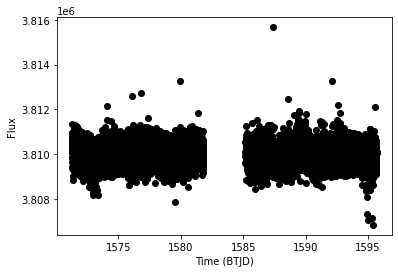

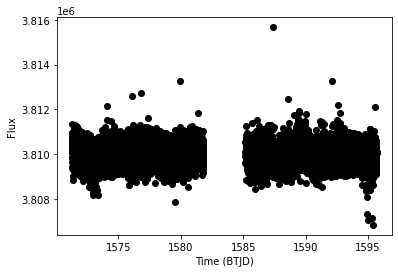

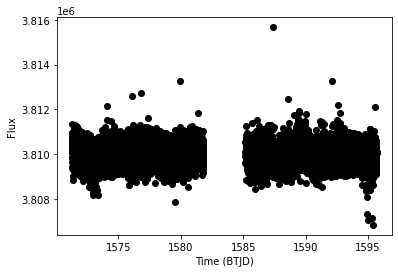

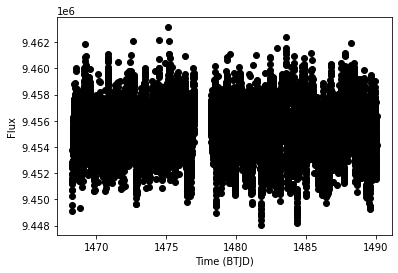

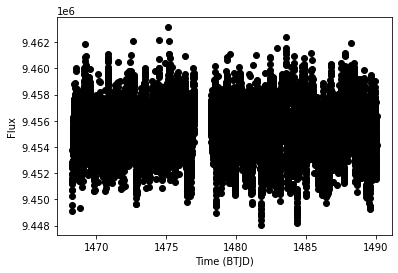

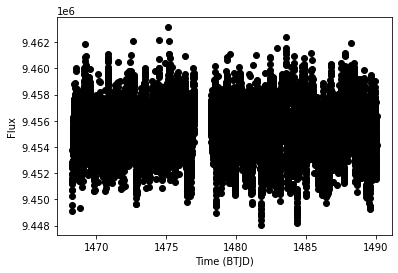

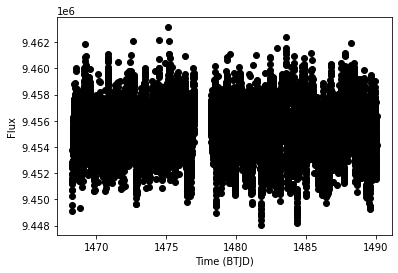

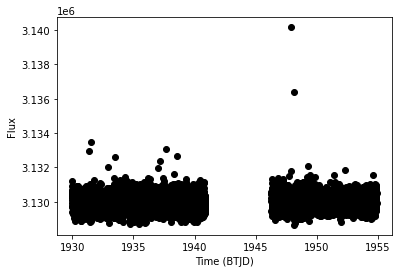

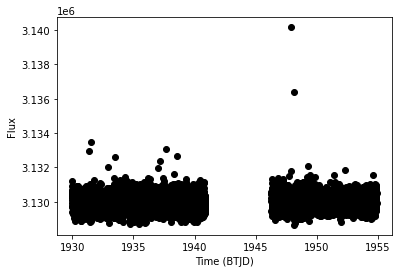

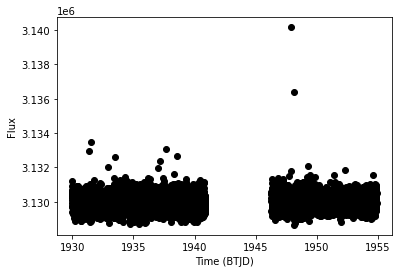

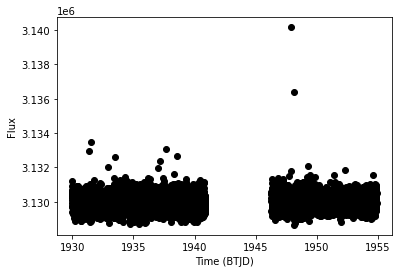

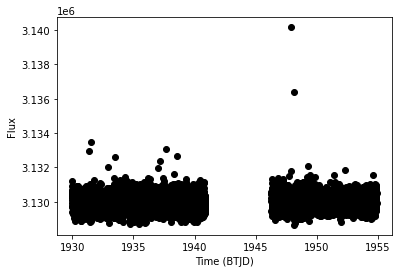

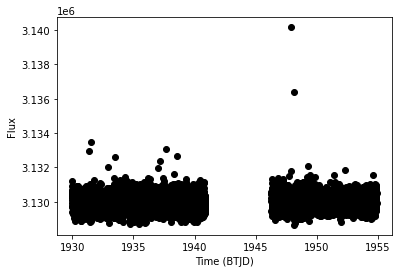

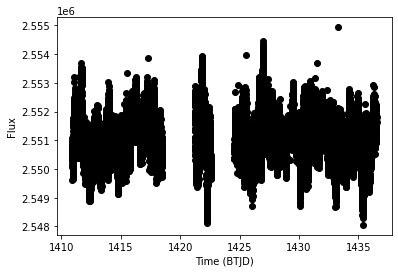

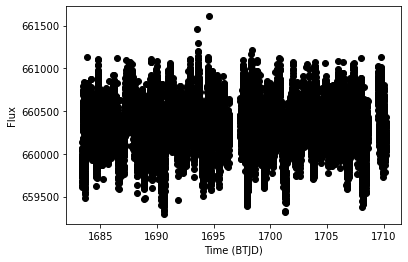

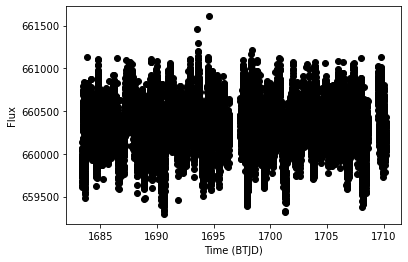

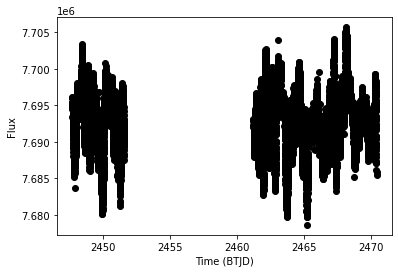

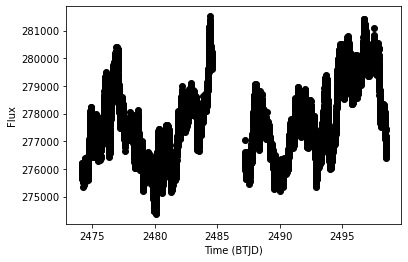

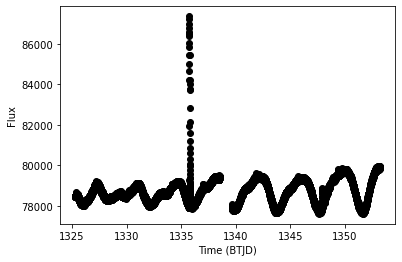

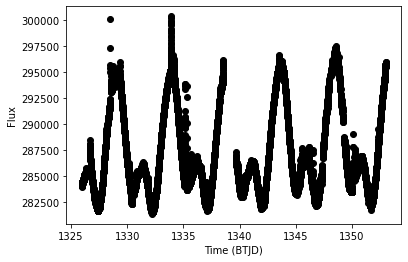

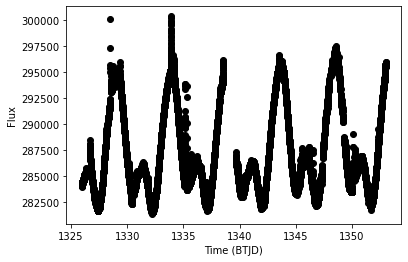

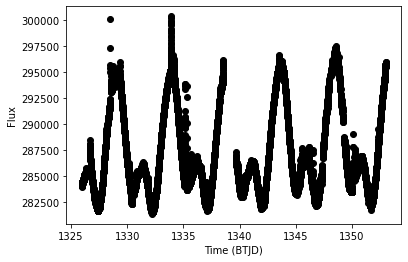

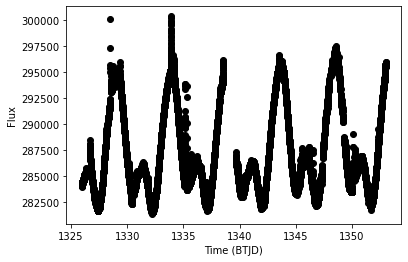

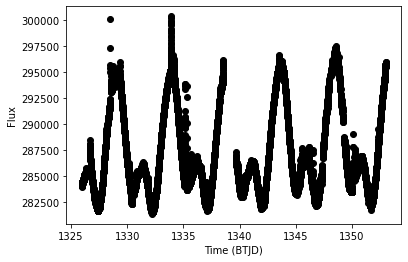

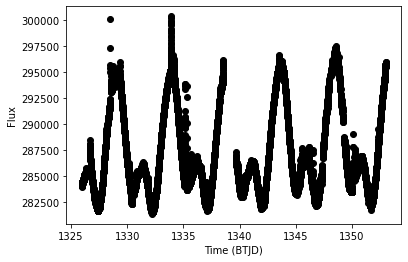

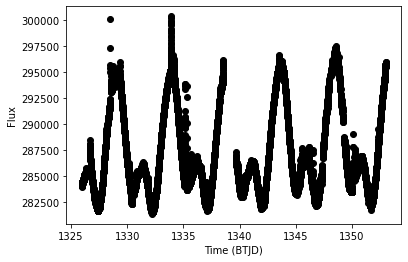

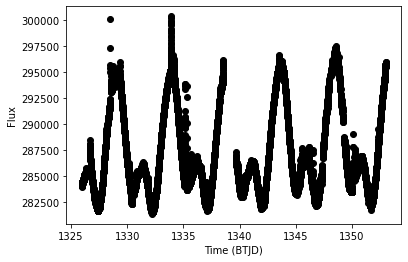

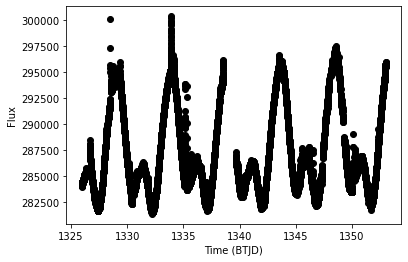

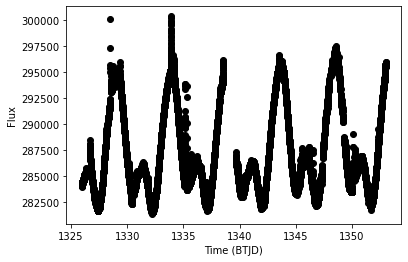

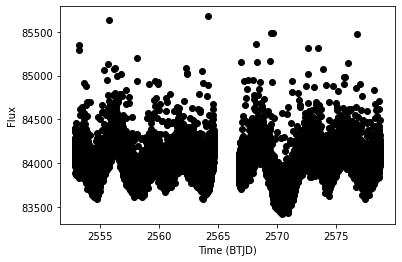

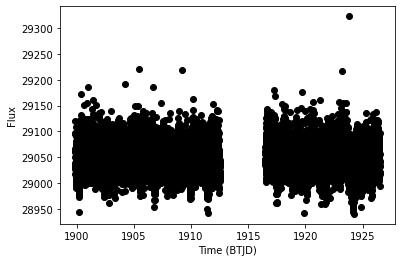

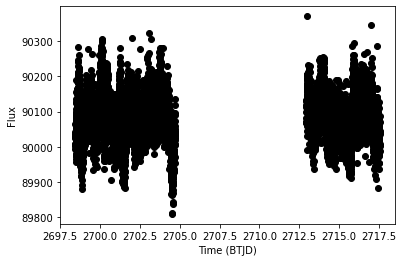

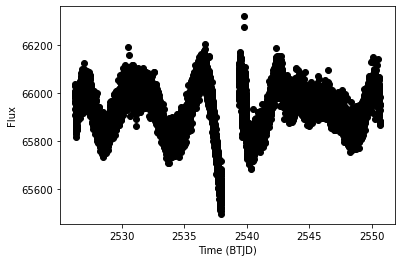

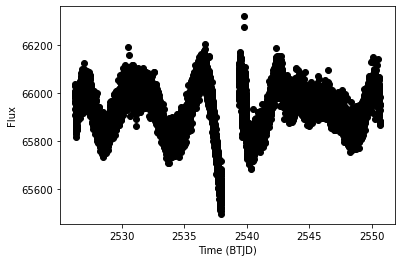

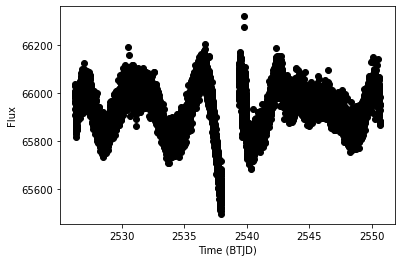

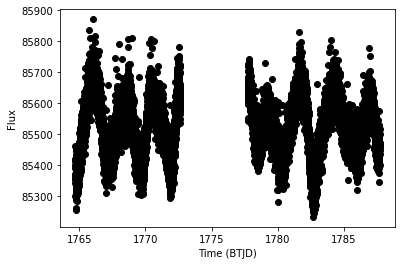

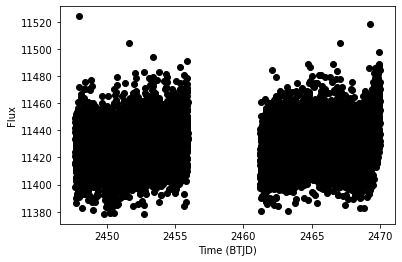

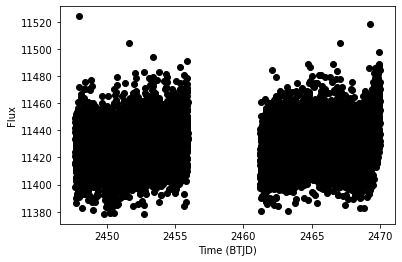

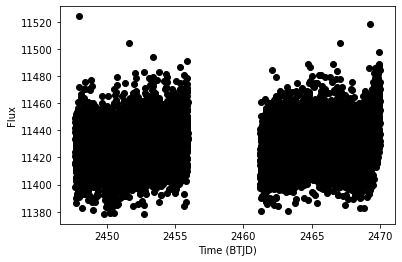

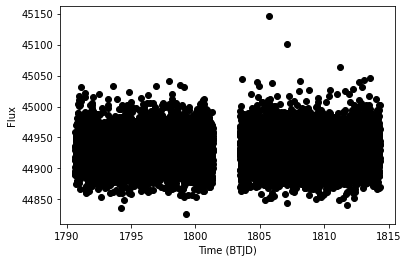

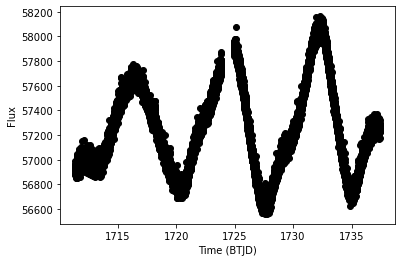

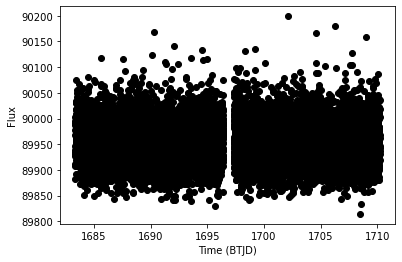

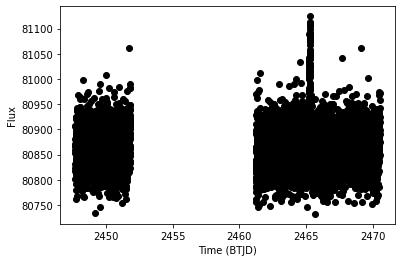

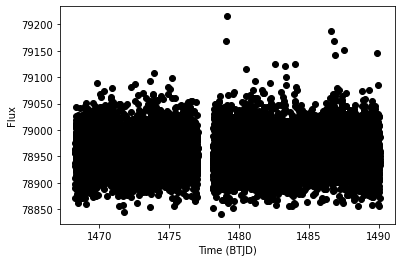

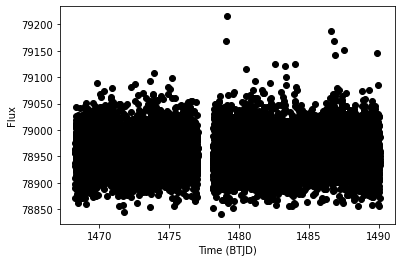

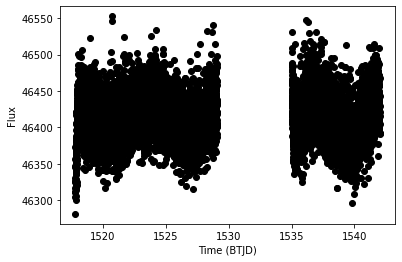

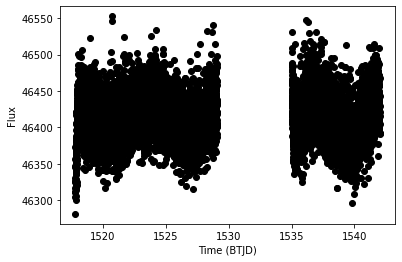

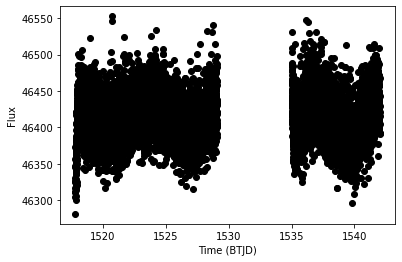

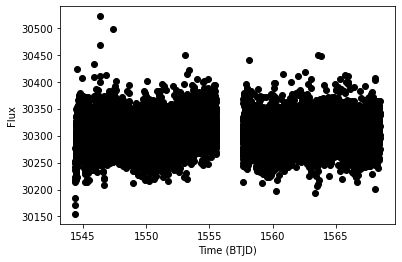

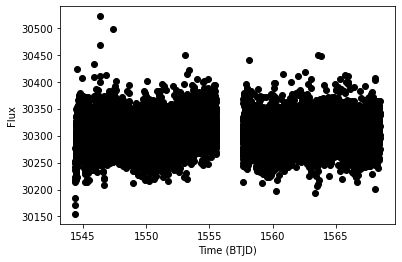

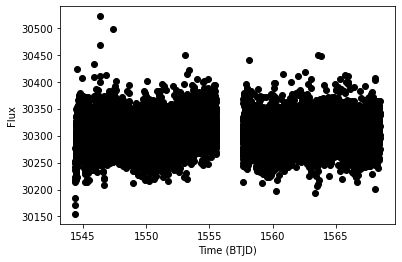

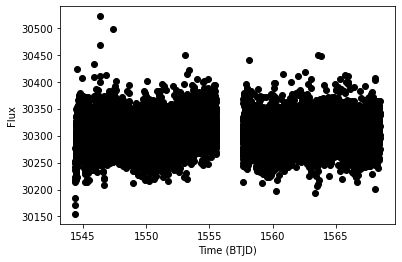

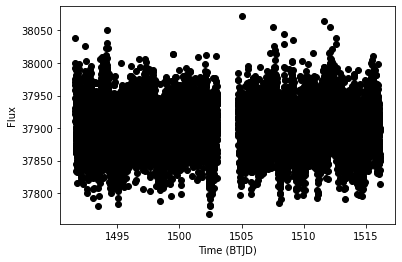

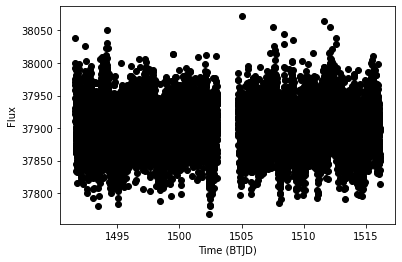

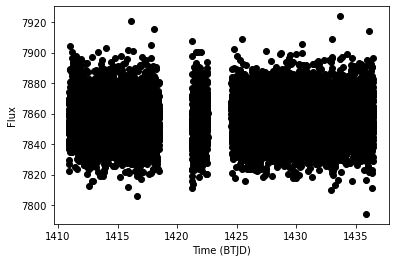

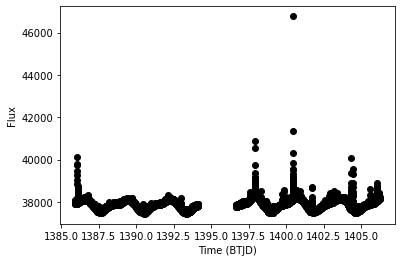

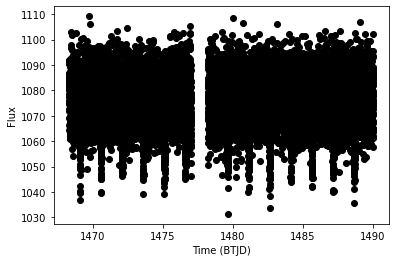

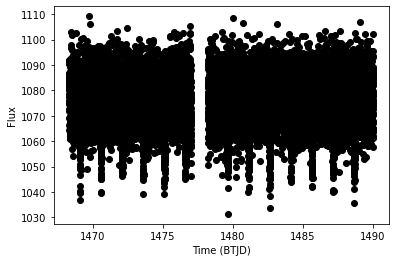

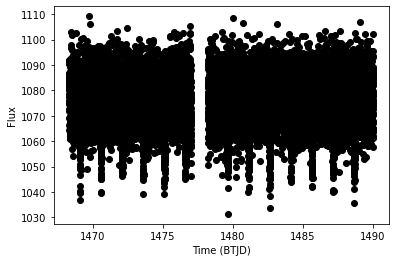

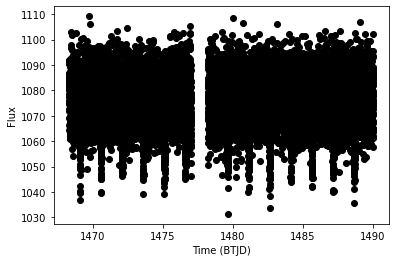

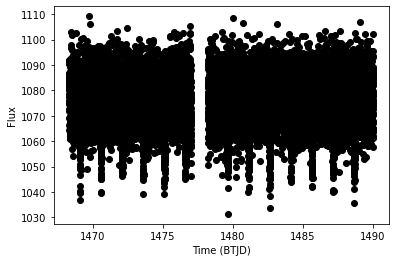

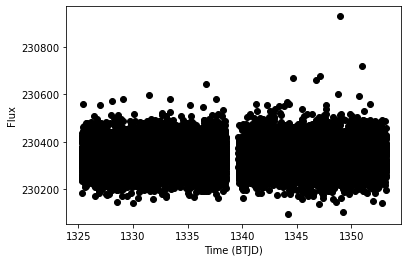

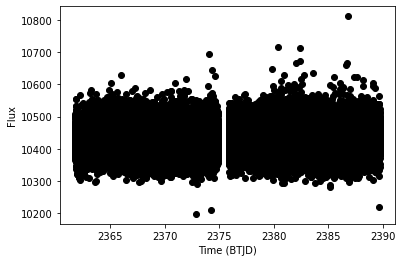

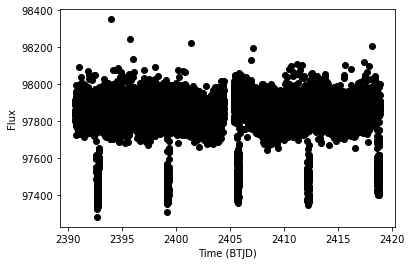

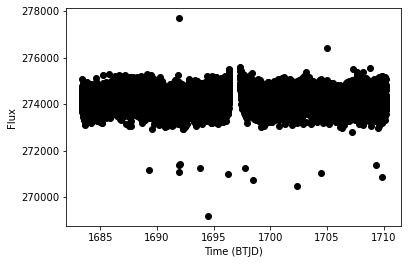

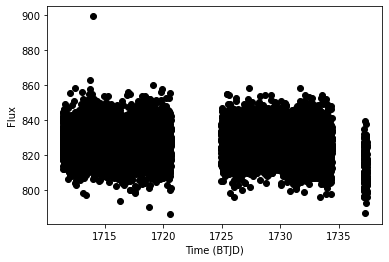

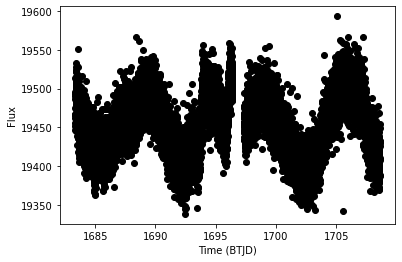

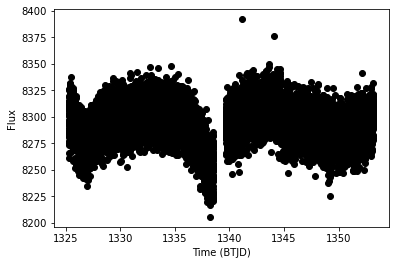

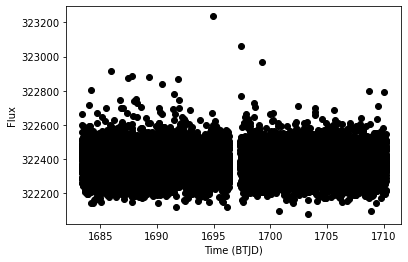

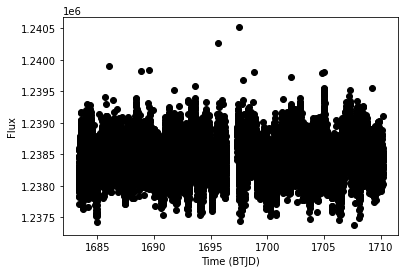

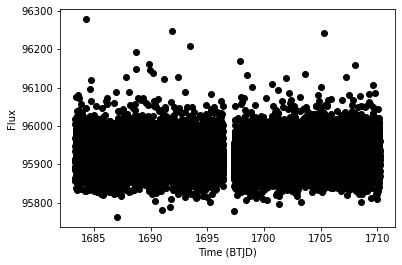

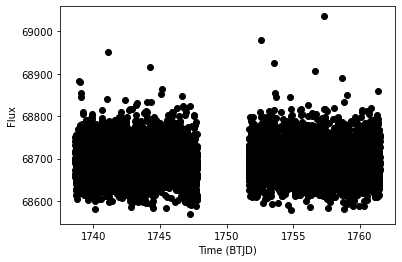

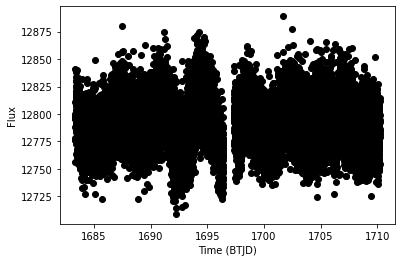

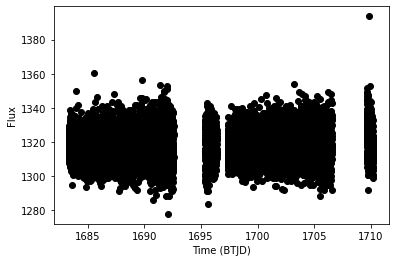

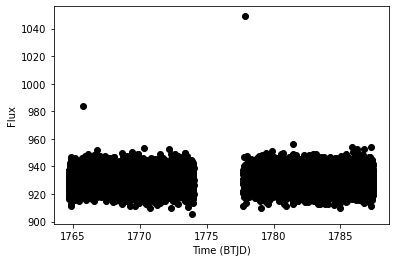

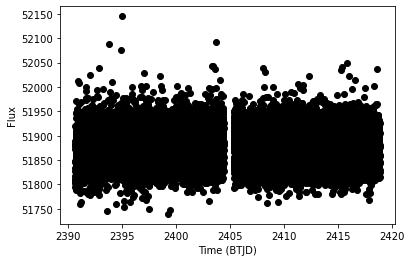

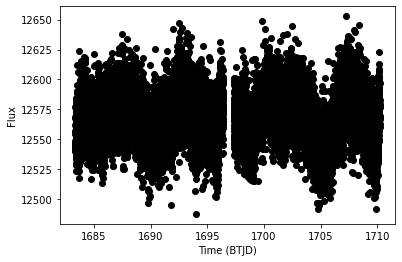

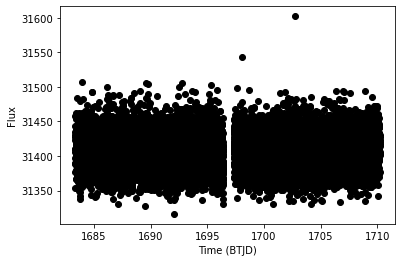

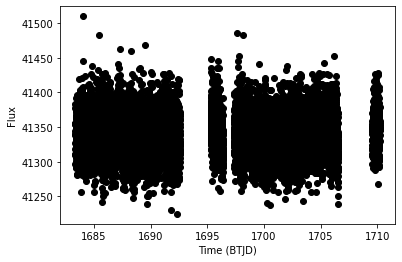

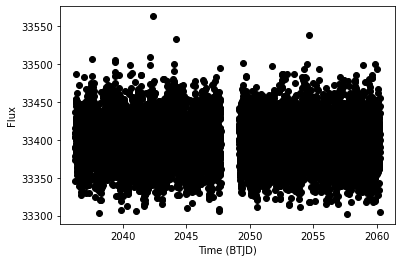

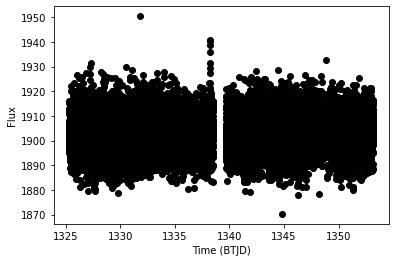

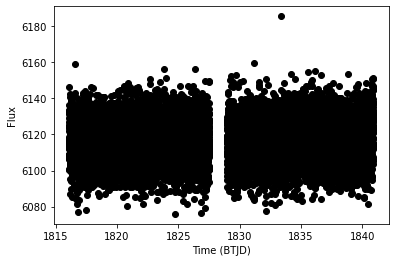

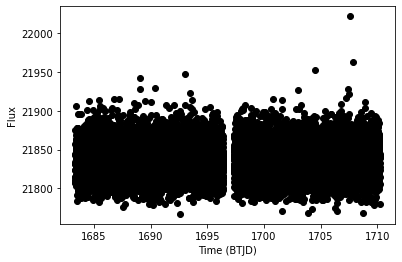

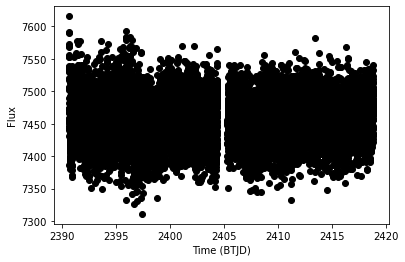

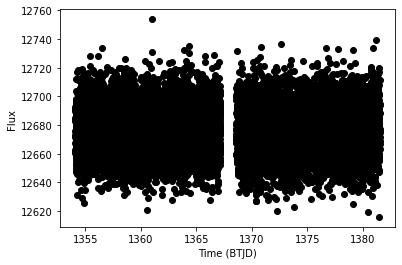

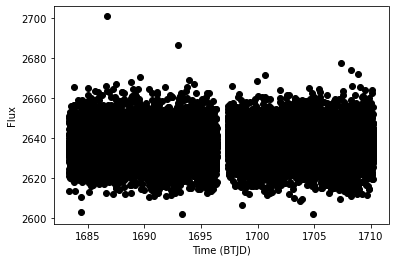

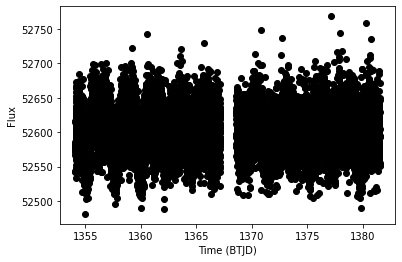

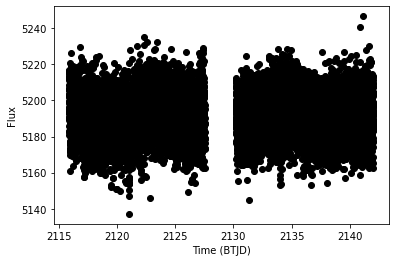

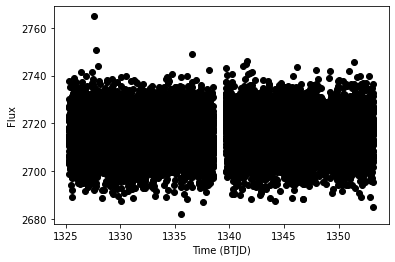

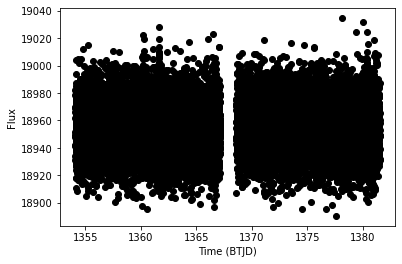

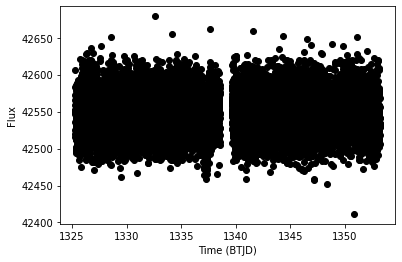

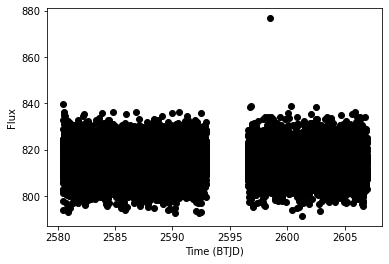

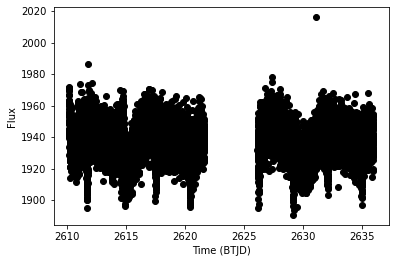

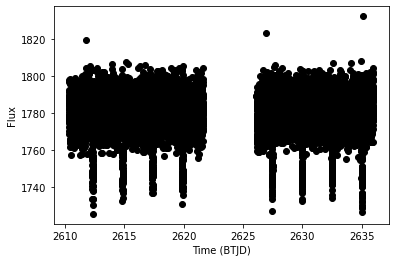

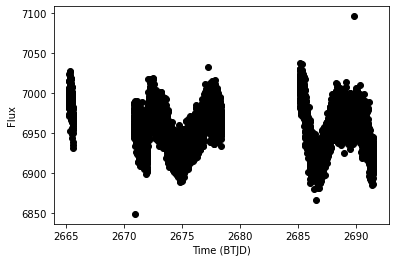

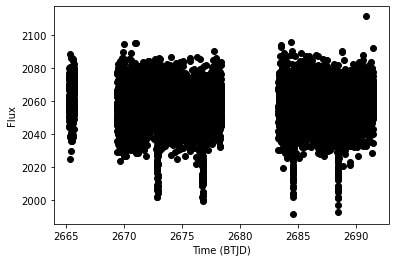

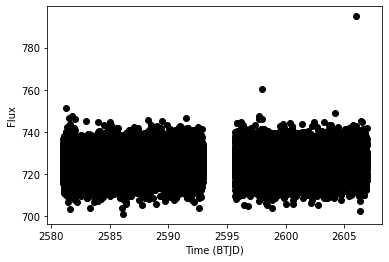

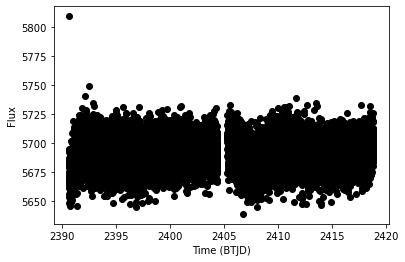

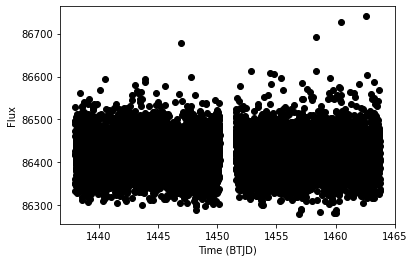

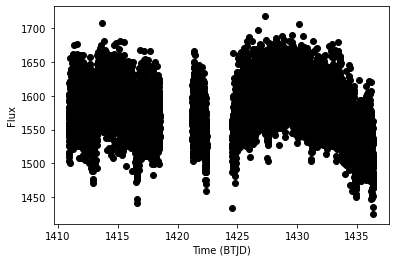

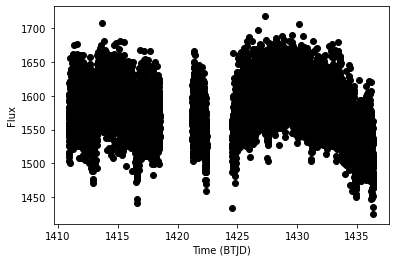

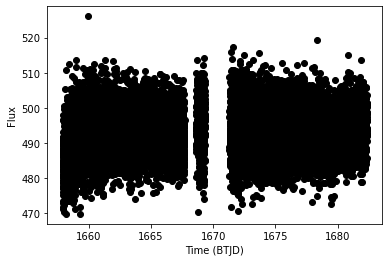

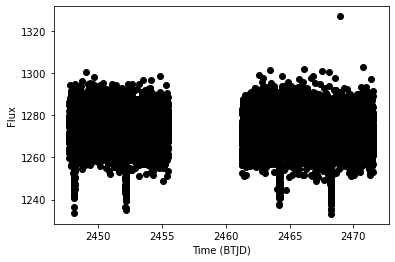

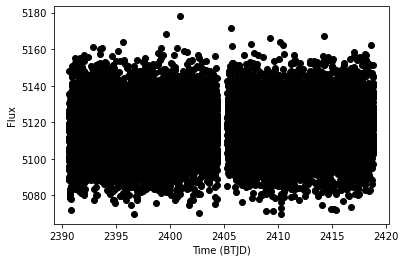

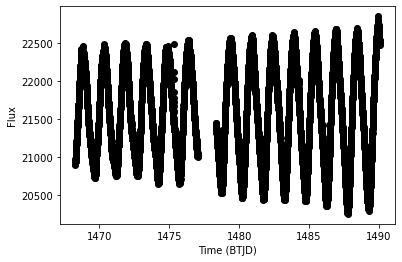

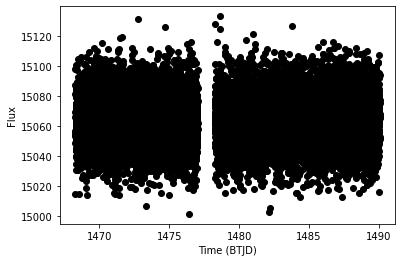

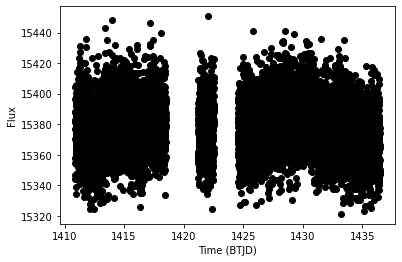

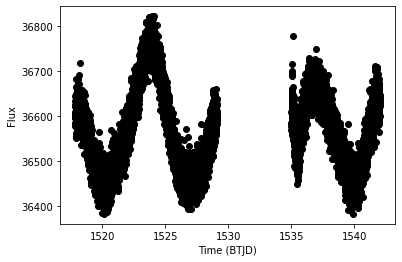

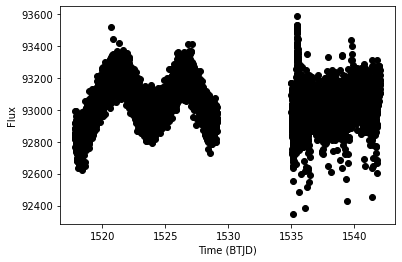

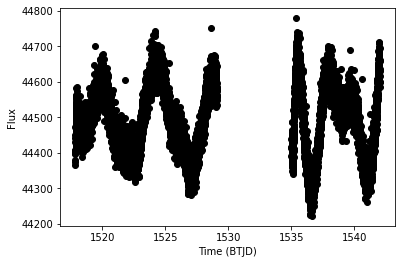

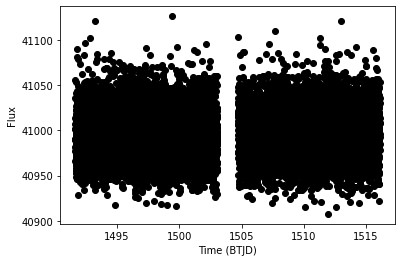

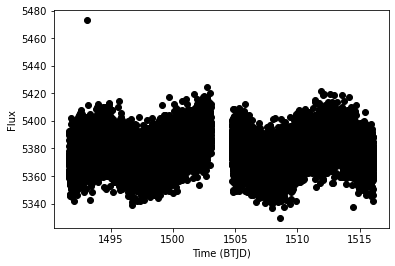

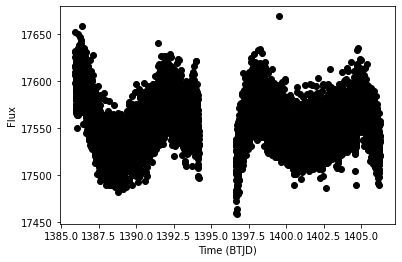

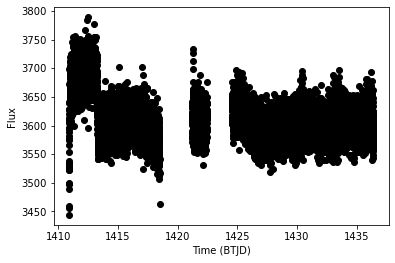

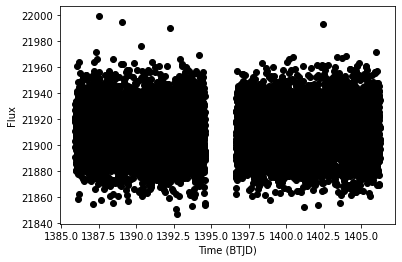

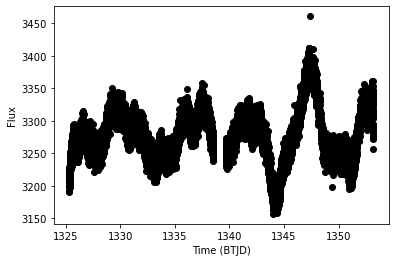

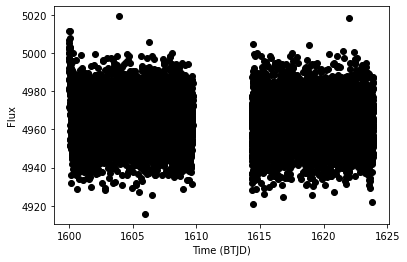

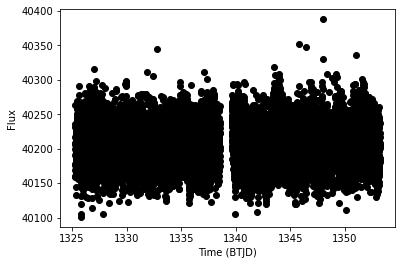

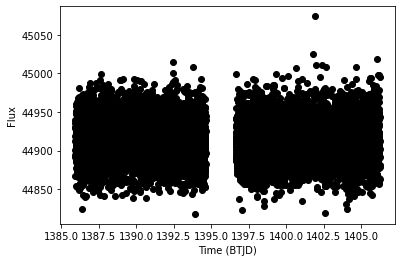

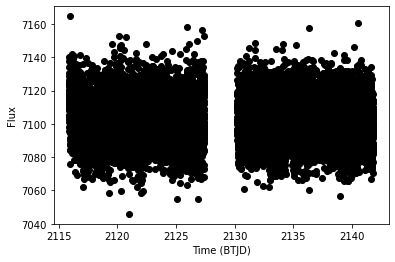

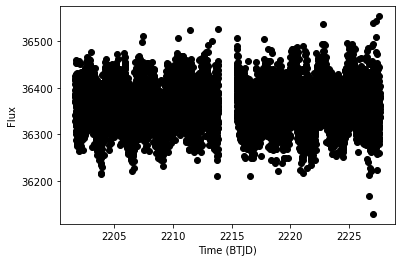

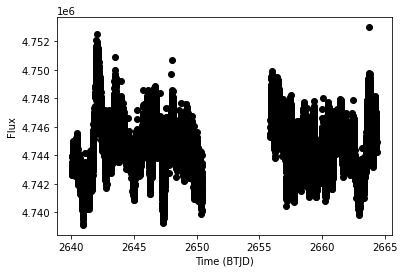

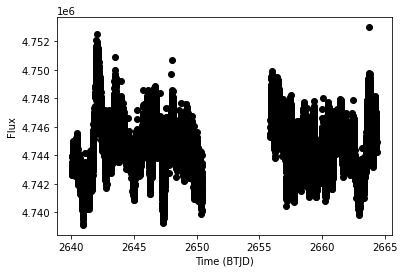

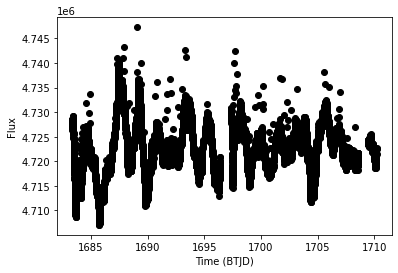

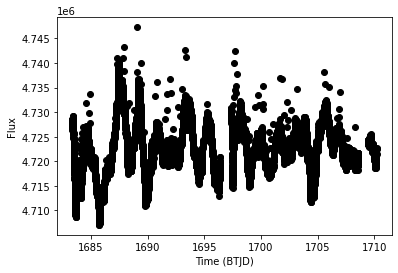

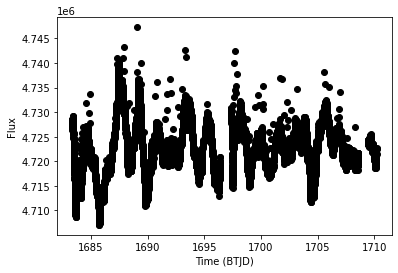

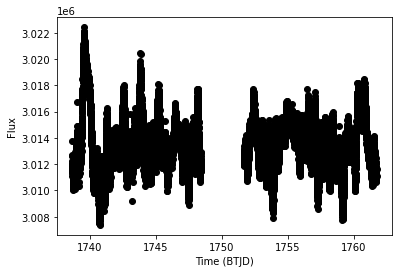

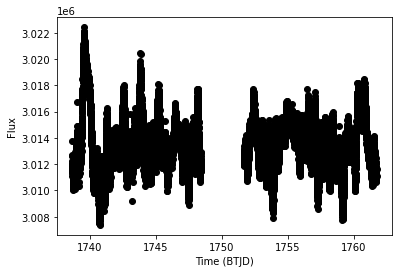

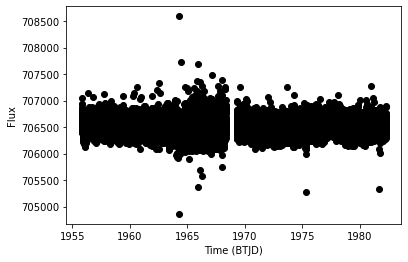

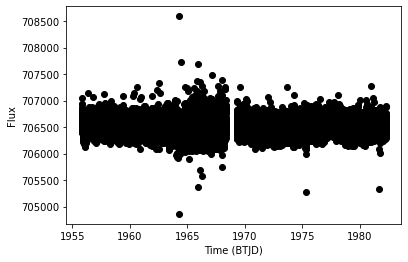

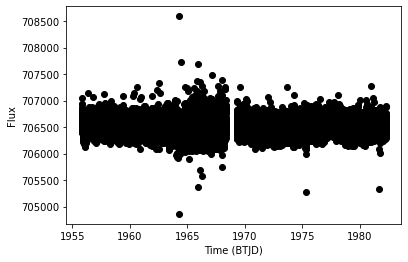

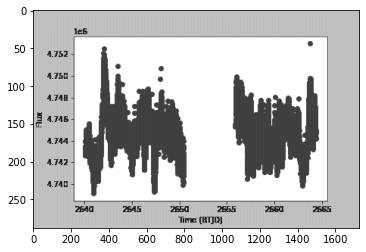

Exoplanet detected! TIC 72437047


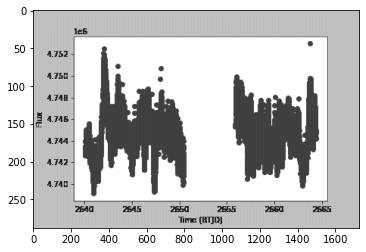

Exoplanet detected! TIC 72437047


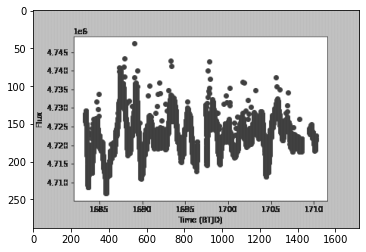

Exoplanet detected! TIC 230061010


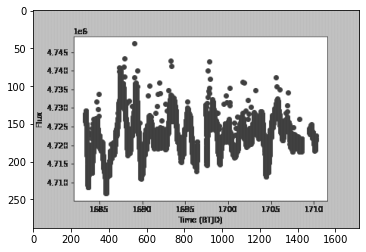

Exoplanet detected! TIC 230061010


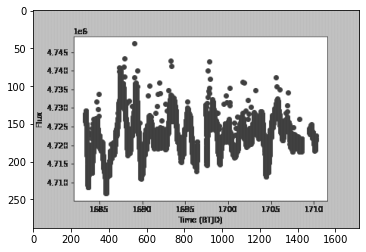

Exoplanet detected! TIC 230061010


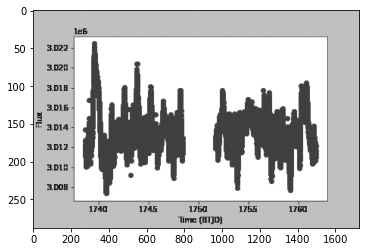

Exoplanet detected! TIC 333225860


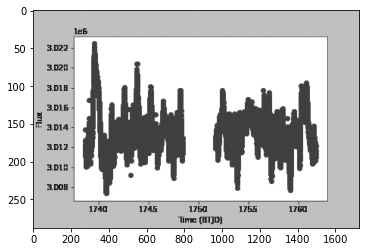

Exoplanet detected! TIC 333225860


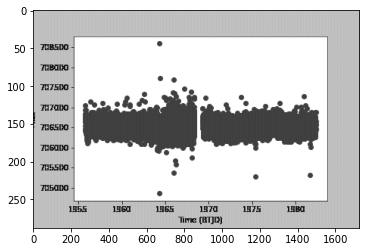

Exoplanet detected! TIC 219483057


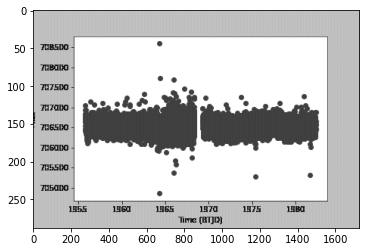

Exoplanet detected! TIC 219483057


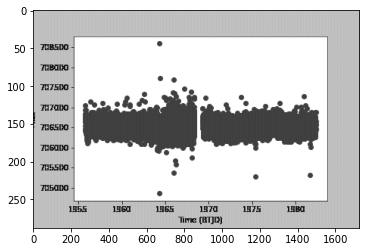

Exoplanet detected! TIC 219483057


In [35]:
predictExo("PS_2022.06.27_08.12.38.csv","TOI_2022.06.29_08.07.35.csv","PS_2022.07.04_02.32.20.csv")